# <center>CITS5017 Project 1<center>
<center>Allison Lau (23123849)<center>

# Import packages

In [15]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from functools import partial
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2

# Load Image Dataset

In [2]:
def load_data(pickle_file):
    with open(pickle_file, "rb") as f:
        data_set = pickle.load(f)
    return data_set[b"data"], data_set[b"labels"], data_set[b"class_names"]

def resize_images(images, size=(96, 96)):
    images_resized = np.array([tf.image.resize(image, size).numpy() for image in images])
    return images_resized

# Call load_data to build the training and validation sets
X_train, y_train, class_names = load_data("train.pkl")
X_val, y_val, _ = load_data("val.pkl")

# Shuffle training and validation data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)

# Check shape of data : Image size = (64, 64, 3)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# Resize images for MobileNetV2 model : Image size = (96, 96, 3)
X_train_resized = resize_images(X_train)
X_val_resized = resize_images(X_val)

# Check shape after resizing
print(f"Resized Training data shape: {X_train_resized.shape}")
print(f"Resized Validation data shape: {X_val_resized.shape}")

Training data shape: (2000, 64, 64, 3)
Validation data shape: (500, 64, 64, 3)
Resized Training data shape: (2000, 96, 96, 3)
Resized Validation data shape: (500, 96, 96, 3)


# Tasks
## (i) Display 20 sample images from training set and validation set

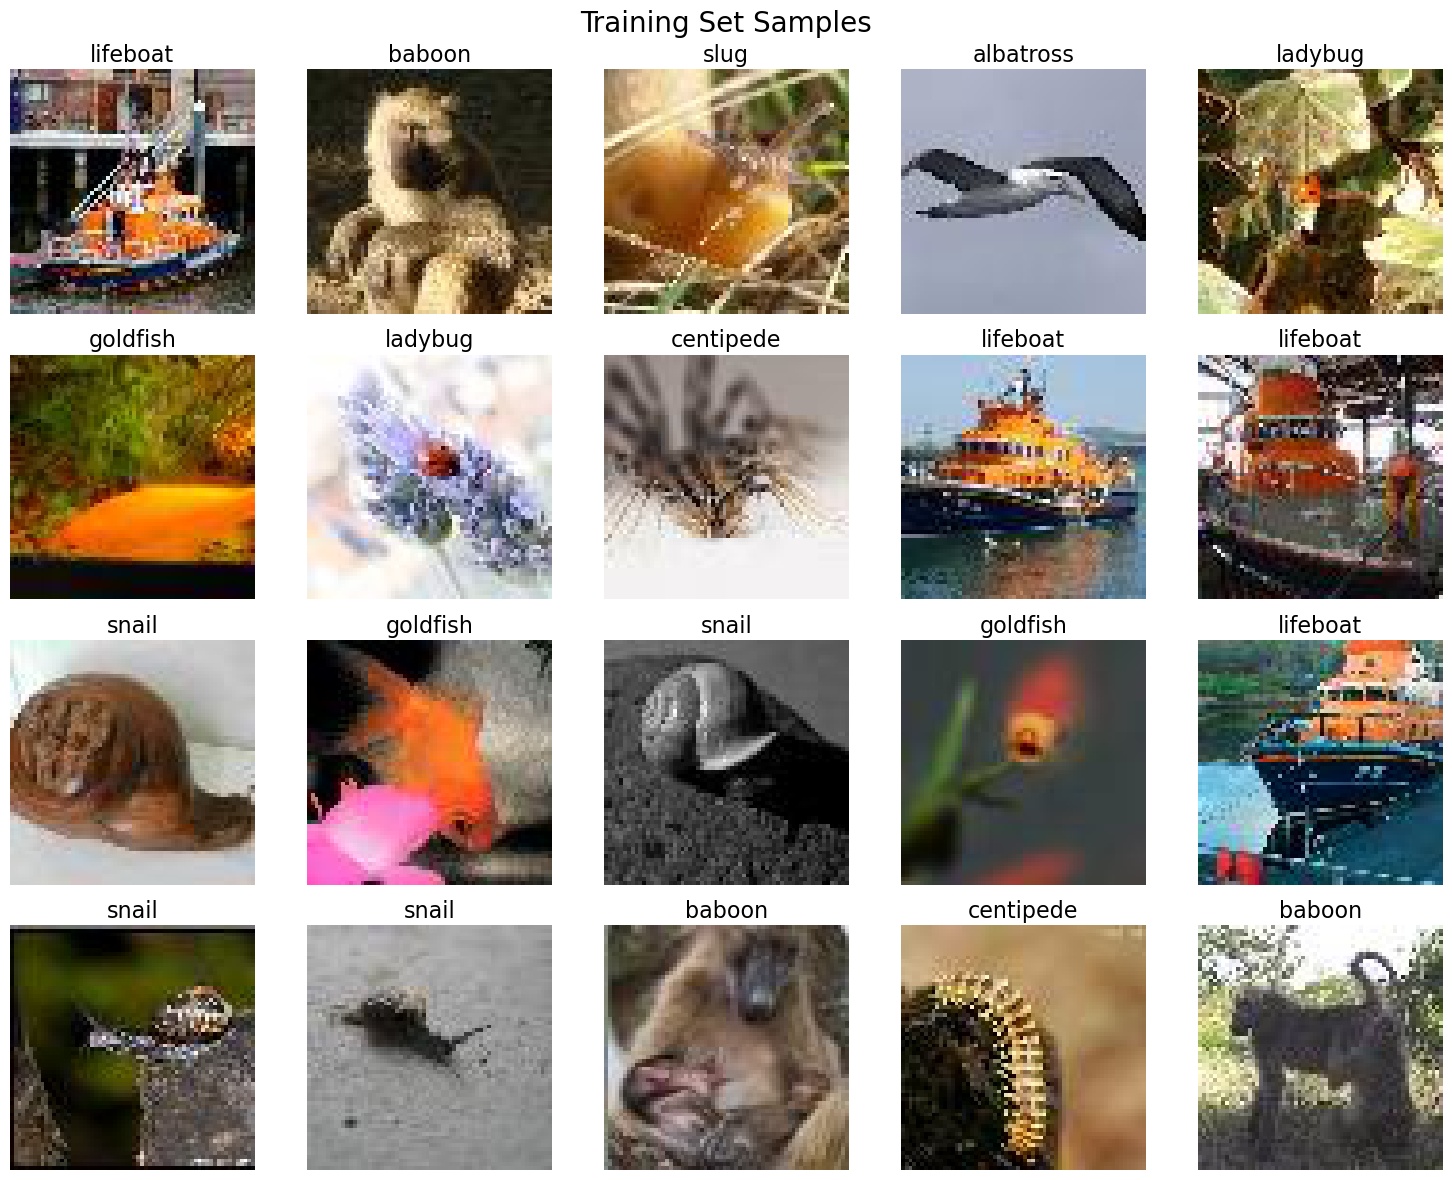

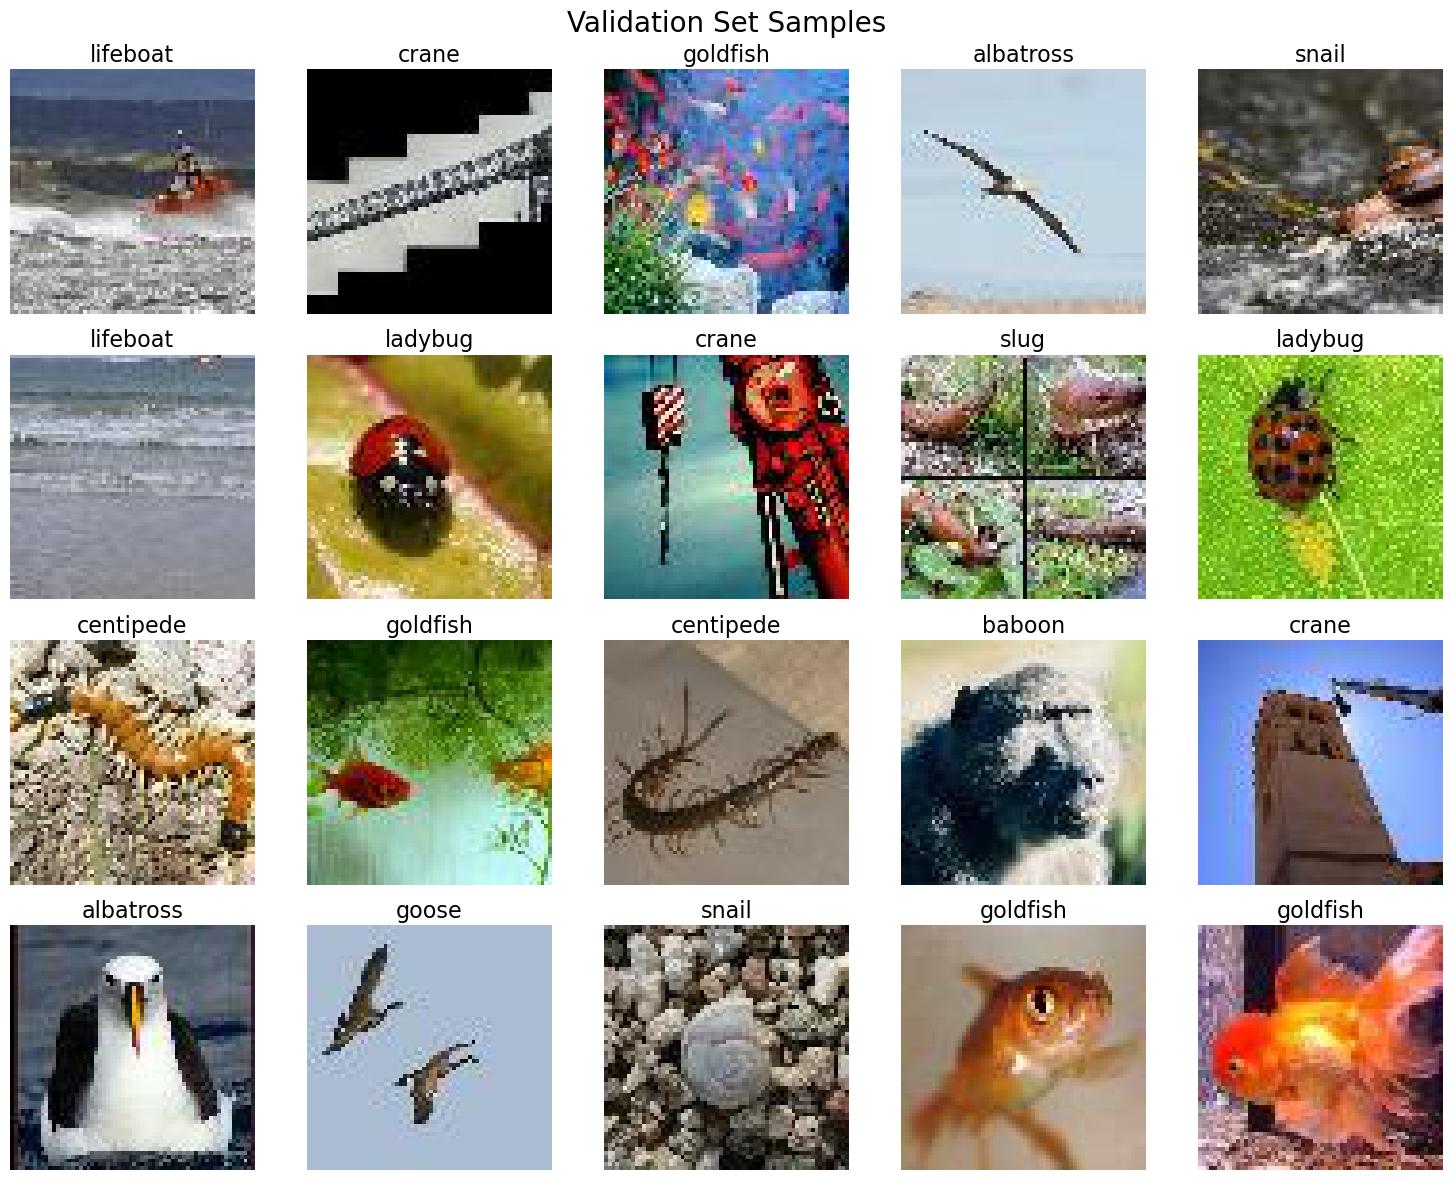

In [31]:
# Function to display sample images from the dataset
def displayImages(images, labels, class_names, num_samples, title, preds=None, condition_indices=None):
    if condition_indices is None: # Sample random images
        indices = np.random.choice(images.shape[0], num_samples)
        sampled_labels = labels[indices]
    else:
        indices = np.random.choice(condition_indices, num_samples)
        if len(preds) == 2: # Has both model's predictions
            sampled_labels_cnn = preds[0][indices]
            sampled_labels_mnv2 = preds[1][indices]
            sampled_labels = labels[indices]
        else:
            sampled_labels = preds[indices]

    sampled_images = images[indices]

    num_rows = num_samples // 5
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3*num_rows))

    if preds and len(preds) == 2:
        for i, (image, label, label_cnn, label_mnv2) in enumerate(zip(sampled_images, sampled_labels, sampled_labels_cnn, sampled_labels_mnv2)):
            row = i // 5
            col = i % 5
            ax = axes[row, col]
            ax.imshow(image)
            title_text = f"True: {class_names[label]}\nCNN: {class_names[label_cnn]}\nMobileNetV2: {class_names[label_mnv2]}"
            ax.set_title(title_text, fontsize=16)
            ax.axis("off")
    else:
        for i, (image, label) in enumerate(zip(sampled_images, sampled_labels)):
            row = i // 5
            col = i % 5
            ax = axes[row, col]
            ax.imshow(image)
            ax.set_title(class_names[label], fontsize=16)
            ax.axis("off")
    
    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

displayImages(X_train, y_train, class_names, 20, "Training Set Samples")
displayImages(X_val, y_val, class_names, 20, "Validation Set Samples")

## (ii) Implementation of CNN Model
### Design of CNN architecture

In [50]:
# Function to create a CNN model
def create_cnn(kernel_size, num_kernels, dropout_rate):
    DefaultConv2D = partial(Conv2D, kernel_size=num_kernels, padding="same", activation="relu", 
                            kernel_initializer="he_normal", kernel_regularizer=l2(0.01))

    model = Sequential([
        # Input Layer
        InputLayer(shape=[64, 64, 3]),
        
        DefaultConv2D(filters=num_kernels, kernel_size=kernel_size),
        MaxPool2D(pool_size=kernel_size),
        BatchNormalization(),
        
        DefaultConv2D(filters=num_kernels*2, kernel_size=kernel_size),
        DefaultConv2D(filters=num_kernels*2, kernel_size=kernel_size),
        MaxPool2D(pool_size=kernel_size),
        BatchNormalization(),
        
        DefaultConv2D(filters=num_kernels*4, kernel_size=kernel_size),
        MaxPool2D(pool_size=kernel_size),
        BatchNormalization(),

        # Flatten and Fully Connected Layers
        Flatten(),
        Dense(units=num_kernels*2, activation="relu", kernel_initializer="he_normal"),
        Dropout(dropout_rate),
        
        Dense(units=num_kernels, activation="relu", kernel_initializer="he_normal"),
        Dropout(dropout_rate),
        
        # Output Layer
        Dense(units=len(class_names), activation="softmax")
    ])
    
    return model

# Function to train CNN model
def train_cnn(model, num_epochs=100):
    # Compile model with a learning rate schedule
    optimizer = AdamW(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Train the model with early stopping
    lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=num_epochs,
                            validation_data=(X_val, y_val),
                            callbacks=[lr_scheduler, early_stopping])
    
    return model, history

### Manual Hyperparameter Tuning
- hyperparameter tuning code
- hyperparameter values experimented
- optimal hyperparameter values

## (iii) Test CNN Model Implementation

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_53 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 21, 21, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,314 (649.66 KB)

 Trainable params: 165,866 (647.91 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.1094 - loss: 8.9440 - val_accuracy: 0.1720 - val_loss: 7.8126 - learning_rate: 0.0010
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.1631 - loss: 7.6913 - val_accuracy: 0.2740 - val_loss: 7.0576 - learning_rate: 0.0010
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.1816 - loss: 7.0835 - val_accuracy: 0.3060 - val_loss: 6.4739 - learning_rate: 0.0010
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2173 - loss: 6.4707 - val_accuracy: 0.3340 - val_loss: 5.9844 - learning_rate: 0.0010
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2634 - loss: 5.8973 - val_accuracy: 0.3300 - val_loss: 5.5140 - learning_rate: 0.0010
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2582 - loss: 5.4299 - val_accuracy: 0.3740 - val_loss: 5.0109 - learning_rate: 0.0010
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.2861 - loss: 4.9777 - 

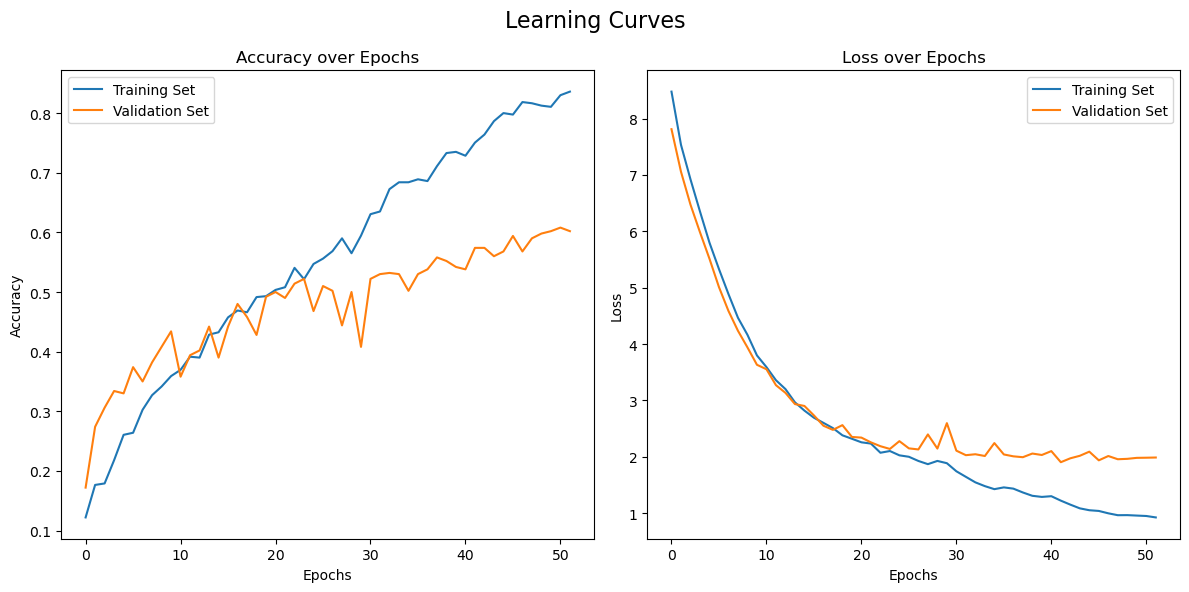

In [51]:
# Function to plot learning curves on same figure
def plot_learning_curves(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Plot accuracy graph
    axs[0].plot(history.history['accuracy'], label='Training Set')
    axs[0].plot(history.history['val_accuracy'], label='Validation Set')
    axs[0].set_title('Accuracy over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    # Plot loss graph
    axs[1].plot(history.history['loss'], label='Training Set')
    axs[1].plot(history.history['val_loss'], label='Validation Set')
    axs[1].set_title('Loss over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    fig.suptitle('Learning Curves', fontsize=16)
    plt.tight_layout()
    plt.show()
    
# Training CNN Model
cnn_model_file = 'Lau_Allison-CNN.keras'

# Optimal hyperparameters
kernel_size = 3
num_kernels = 32
dropout_rate = 0.5
num_epochs = 100

if os.path.exists(cnn_model_file):
    # Load and display model summary
    cnn_model = tf.keras.models.load_model(cnn_model_file)
    print(f"Load '{cnn_model_file}' model successfully")
    
    # Compile the model with a tiny learning rate
    optimizer = AdamW(learning_rate=1e-6)
    cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    cnn_model.summary()
    
    # Train the model for 1 more epoch
    cnn_history = cnn_model.fit(X_train, y_train, epochs=1, validation_data=(X_val, y_val))
    
else:
    # Create CNN model
    cnn_model = create_cnn(kernel_size, num_kernels, dropout_rate)
    
    # Train CNN model
    cnn_model, cnn_history = train_cnn(cnn_model, num_epochs)
    
    # Save the model
    cnn_model.save(cnn_model_file)
    print(f"Save '{cnn_model_file}' model successfully")

    # Plot learning curves
    plot_learning_curves(cnn_history)

### Evaluation of CNN Model

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Training Accuracy: 0.9350


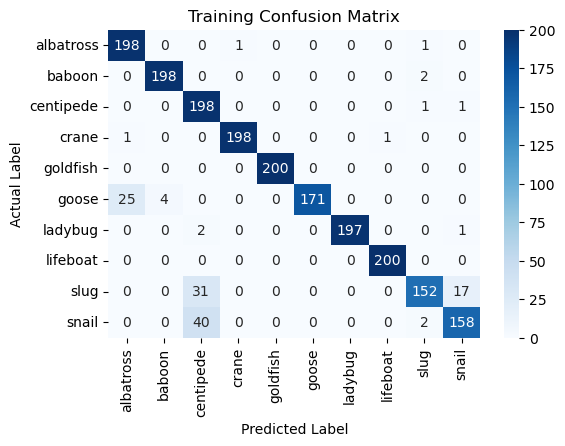

Validation Accuracy: 0.5940


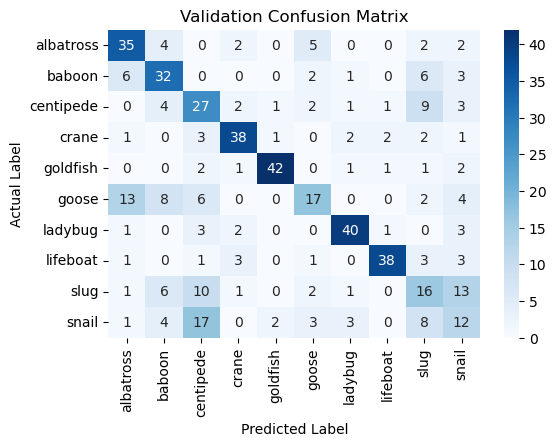

In [49]:
# Function to display confusion matrix
def display_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)
    plt.show()

# Function to evaluate a model
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Perform predictions on training and validation sets
    y_train_pred = np.argmax(model.predict(X_train), axis=1)
    y_val_pred = np.argmax(model.predict(X_val), axis=1)
    
    # Compute prediction accuracy and confusion matrix
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    train_cm = confusion_matrix(y_train, y_train_pred)
    val_cm = confusion_matrix(y_val, y_val_pred)
    
    # Print
    print(f"Training Accuracy: {train_accuracy:.4f}")
    display_confusion_matrix(train_cm, "Training Confusion Matrix")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    display_confusion_matrix(val_cm, "Validation Confusion Matrix")
    
    return y_train_pred, y_val_pred

# Evaluate CNN model
cnn_train_pred, cnn_val_pred = evaluate_model(cnn_model, X_train, y_train, X_val, y_val)

## (iv) Transfer Learning using MobileNetV2

In [107]:
# Function to create MobileNetV2 model
def create_mobilenetv2(input_shape=(96, 96, 3), num_classes=10):
    base_model = MobileNetV2(input_shape=input_shape, weights="imagenet", include_top=False)
    avg = GlobalAveragePooling2D(name='global_avg_pool')(base_model.output)
    output = Dense(units=128, activation='relu', name='dense_128')(avg)
    output = Dropout(0.5)(output)
    output = Dense(units=num_classes, activation='softmax', name='output_layer')(output)
    model = Model(inputs=base_model.input, outputs=output)
    
    return base_model, model

# Function to train MobileNetV2 model
def train_mobilenetv2(base_model, model):
    # Freeze layers from base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Train model for few epochs
    optimizer = SGD(learning_rate=0.1, momentum=0.9)
    model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(X_train_resized, y_train, epochs=10, validation_data=(X_val_resized, y_val))
    
    # Unfreeze layer 90 onwards
    for layer in base_model.layers[90:]:
        layer.trainable = True
    
    # Train for another 30 epochs with low learning rate
    optimizer = SGD(learning_rate=0.001, momentum=0.9) # low learning rate
    model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(X_train_resized, y_train, epochs=30, validation_data=(X_val_resized, y_val))
    
    return model

# Function to display only first and last 5 layers
def display_5_layers(model):
    print("First 5 Layers:")
    first_1= r'^input_layer_.*'
    first_5 = r'^expanded_conv_depthwise$'
    model.summary(line_length=100, layer_range=[first_1, first_5])
    
    print("Last 5 Layers:")
    last_1 = r'^out_relu$'
    last_5 = r'^output_layer$'
    model.summary(line_length=100, layer_range=[last_1, last_5])

# Create the model
base_model, model = create_mobilenetv2()
display_5_layers(model)

First 5 Layers:


Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_87 (InputLayer) │ (None, 96, 96, 3)       │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Conv1 (Conv2D)              │ (None, 48, 48, 32)      │            864 │ input_layer_87[0][0]    │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ bn_Conv1                    │ (None, 48, 48, 32)      │            128 │ Conv1[0][0]             │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Conv1_relu (ReLU)           │ (None, 48, 48, 32)      │              0 │ bn_Conv1[0][0]          │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ expanded_conv_depthwise     │ (None, 48, 48, 32)      │            288 │ Conv1_relu[0][0]        │
│ (DepthwiseConv2D)           │                         │                │                         │
└─────────────────────────────┴─────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 2,389,130 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

Last 5 Layers:


Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ out_relu (ReLU)             │ (None, 3, 3, 1280)      │              0 │ Conv_1_bn[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ global_avg_pool             │ (None, 1280)            │              0 │ out_relu[0][0]          │
│ (GlobalAveragePooling2D)    │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dense_128 (Dense)           │ (None, 128)             │        163,968 │ global_avg_pool[0][0]   │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dropout_81 (Dropout)        │ (None, 128)             │              0 │ dense_128[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ output_layer (Dense)        │ (None, 10)              │          1,290 │ dropout_81[0][0]        │
└─────────────────────────────┴─────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 2,389,130 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

### Training MobileNetV2 Model

In [108]:
# Training MobileNetV2 model
mnv2_model_file = 'Lau_Allison-MobileNetV2.keras'

# Create and compile the model
base_model, mnv2_model = create_mobilenetv2()

mnv2_model = train_mobilenetv2(base_model, mnv2_model)

# Save the model
mnv2_model.save(mnv2_model_file)
print(f"Save '{mnv2_model_file}' model successfully")

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.0973 - loss: 3.5461 - val_accuracy: 0.1000 - val_loss: 2.3102
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.0966 - loss: 2.3092 - val_accuracy: 0.1000 - val_loss: 2.3092
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.0957 - loss: 2.3102 - val_accuracy: 0.1000 - val_loss: 2.3057
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.1129 - loss: 2.3049 - val_accuracy: 0.1020 - val_loss: 2.3169
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.0787 - loss: 2.3135 - val_accuracy: 0.1000 - val_loss: 2.3085
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.1086 - loss: 2.3081 - val_accuracy: 0.1000 - val_loss: 2.3112
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.0928 - loss: 2.3152 - val_accuracy: 0.1000 - val_loss: 2.3071
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.0926 - loss: 2.3096 - val_accuracy: 0.1000 - v

### Evaluation of MobileNetV2 Model

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Training Accuracy: 0.8865


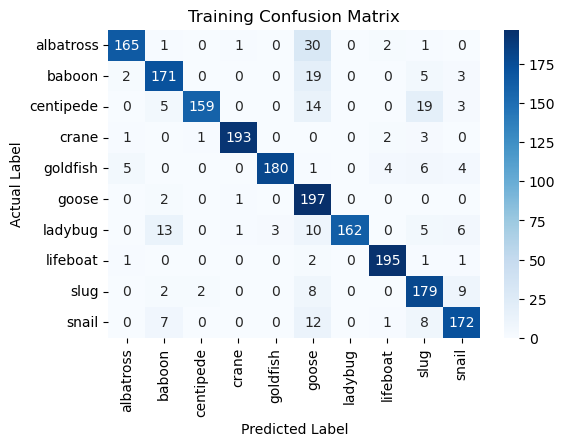

Validation Accuracy: 0.4180


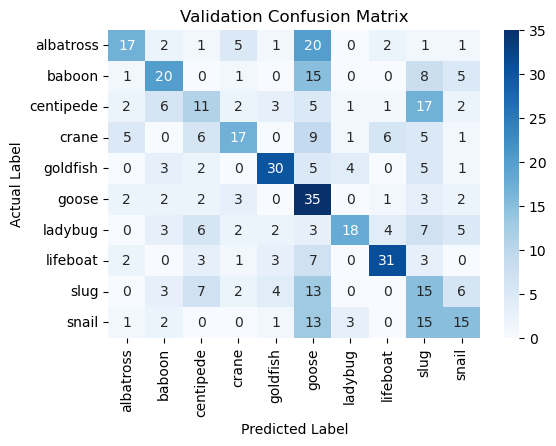

In [113]:
# Evaluate MobileNetV2 model
mnv2_train_pred, mnv2_val_pred = evaluate_model(mnv2_model, X_train_resized, y_train, X_val_resized, y_val)

### Display samples of correct and incorrect predictions

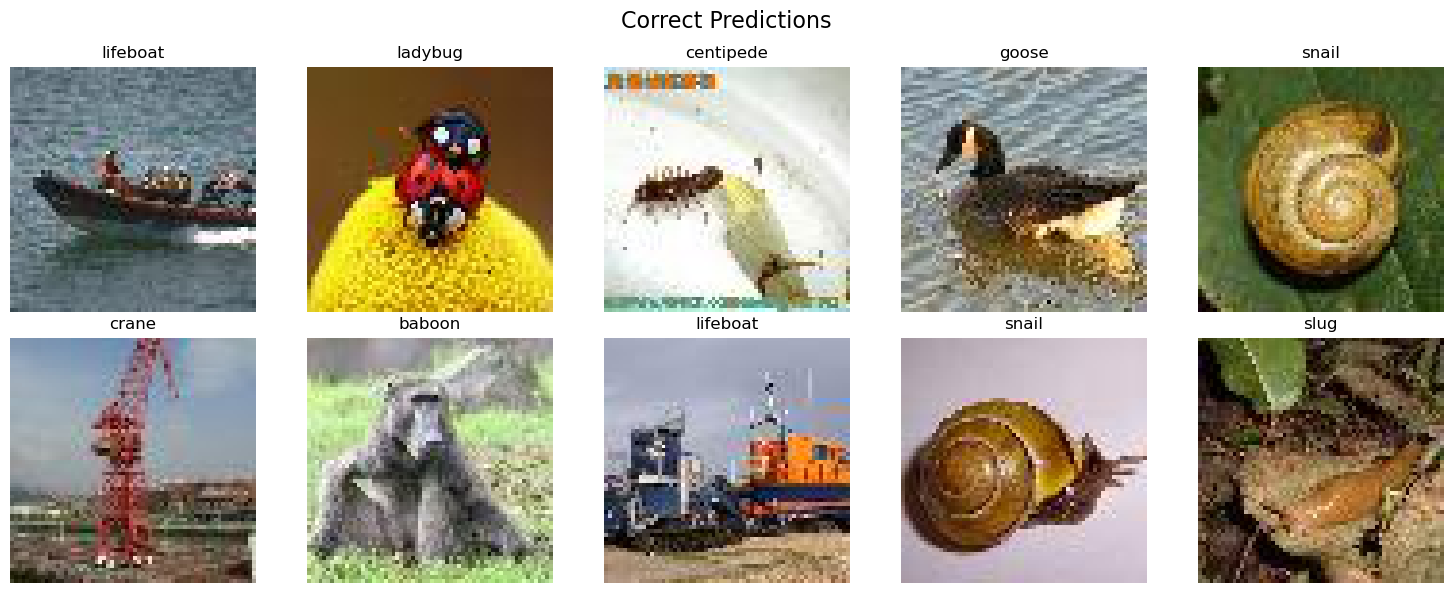

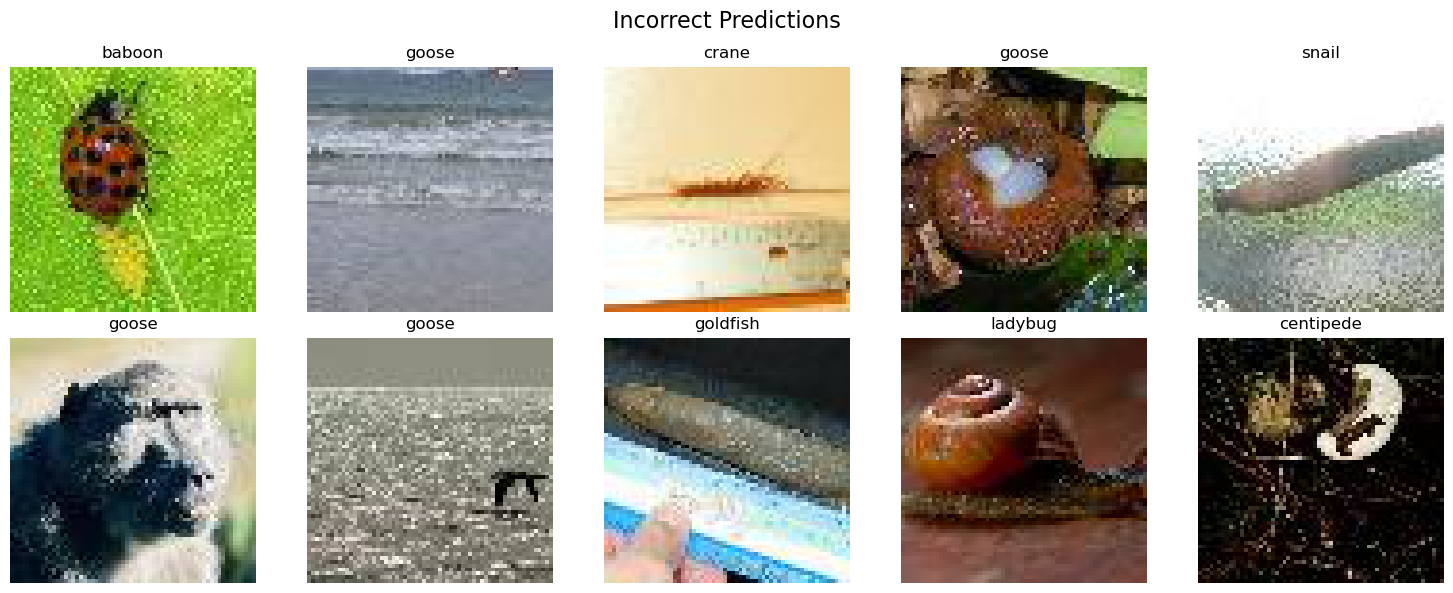

In [136]:
correct_indices = np.where(mnv2_val_pred == y_val)[0]
displayImages(X_val, y_val, class_names, 10, "Correct Predictions", 
              preds=mnv2_val_pred, condition_indices=correct_indices)

incorrect_indices = np.where(mnv2_val_pred != y_val)[0]
displayImages(X_val, y_val, class_names, 10, "Incorrect Predictions", 
              preds=mnv2_val_pred, condition_indices=incorrect_indices)

## (v) Comparisons

### Model Classification Performances

In [146]:
def model_performance(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average=None)
    return accuracy, f1, precision

def print_precision(precision):
    df = pd.DataFrame({
        'Class': class_names,
        'Precision': [f"{prec:.2f}" for prec in precision]
    })
    print(df.to_string(index=False))

accuracy_cnn, f1_cnn, precision_cnn = model_performance(y_val, cnn_val_pred)
accuracy_mnv2, f1_mnv2, precision_mnv2 = model_performance(y_val, mnv2_val_pred)

print("CNN Model Performance:")
print(f"Accuracy: {accuracy_cnn:.2f}")
print(f"F1 Score: {f1_cnn:.2f}")
print(f"Precision per Class:")
print_precision(precision_cnn)

print("\nMobileNetV2 Performance:")
print(f"Accuracy: {accuracy_mnv2:.2f}")
print(f"F1 Score: {f1_mnv2:.2f}")
print(f"Precision per Class:")
print_precision(precision_mnv2)

CNN Model Performance:
Accuracy: 0.31
F1 Score: 0.24
Precision per Class:
    Class Precision
albatross      0.35
   baboon      0.19
centipede      0.12
    crane      0.60
 goldfish      0.48
    goose      0.16
  ladybug      0.30
 lifeboat      0.31
     slug      0.50
    snail      0.00

MobileNetV2 Performance:
Accuracy: 0.42
F1 Score: 0.43
Precision per Class:
    Class Precision
albatross      0.57
   baboon      0.49
centipede      0.29
    crane      0.52
 goldfish      0.68
    goose      0.28
  ladybug      0.67
 lifeboat      0.69
     slug      0.19
    snail      0.39


### Model Complexities

In [ ]:
def model_complexity(model):
    num_params = model.count_params()
    num_layers = len(model.layers)
    return num_params, num_layers

num_params_cnn, num_layers_cnn = model_complexity(cnn_model)
num_params_mnv2, num_layers_mnv2 = model_complexity(mnv2_model)

print("CNN Model Complexity:")
print(f"Number of Parameters: {num_params_cnn}")
print(f"Number of Layers: {num_layers_cnn}")

print("\nMobileNetV2 Model Complexity:")
print(f"Number of Parameters: {num_params_mnv2}")
print(f"Number of Layers: {num_layers_mnv2}")

### Display images where
- both models predict correctly
- both models predict incorrectly
- CNN predicts correctly but MobileNetV2 predicts incorrectly
- CNN predicts incorrectly but MobileNetV2 predicts correctly

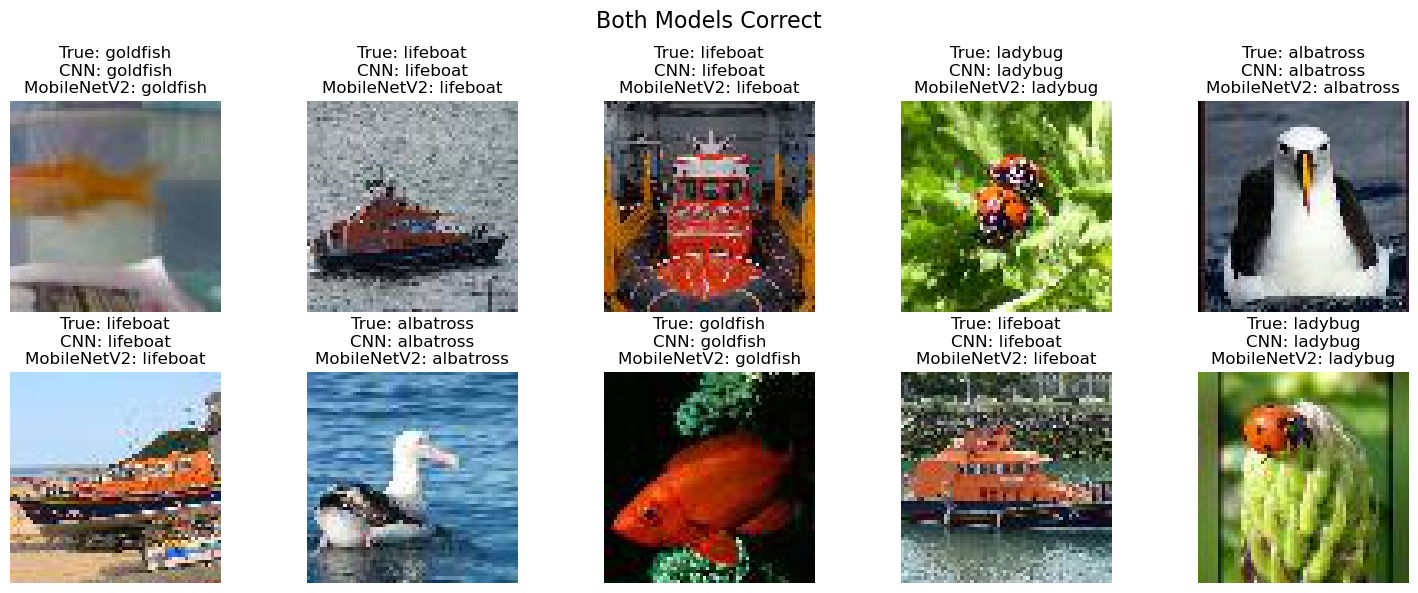

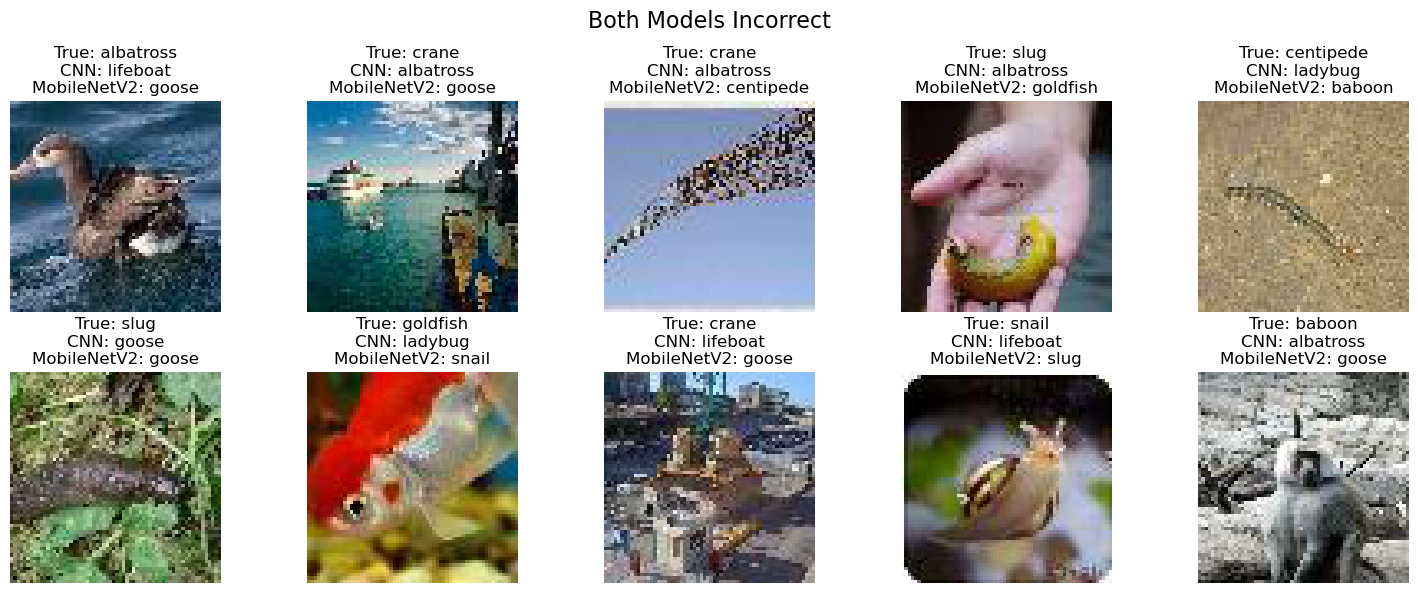

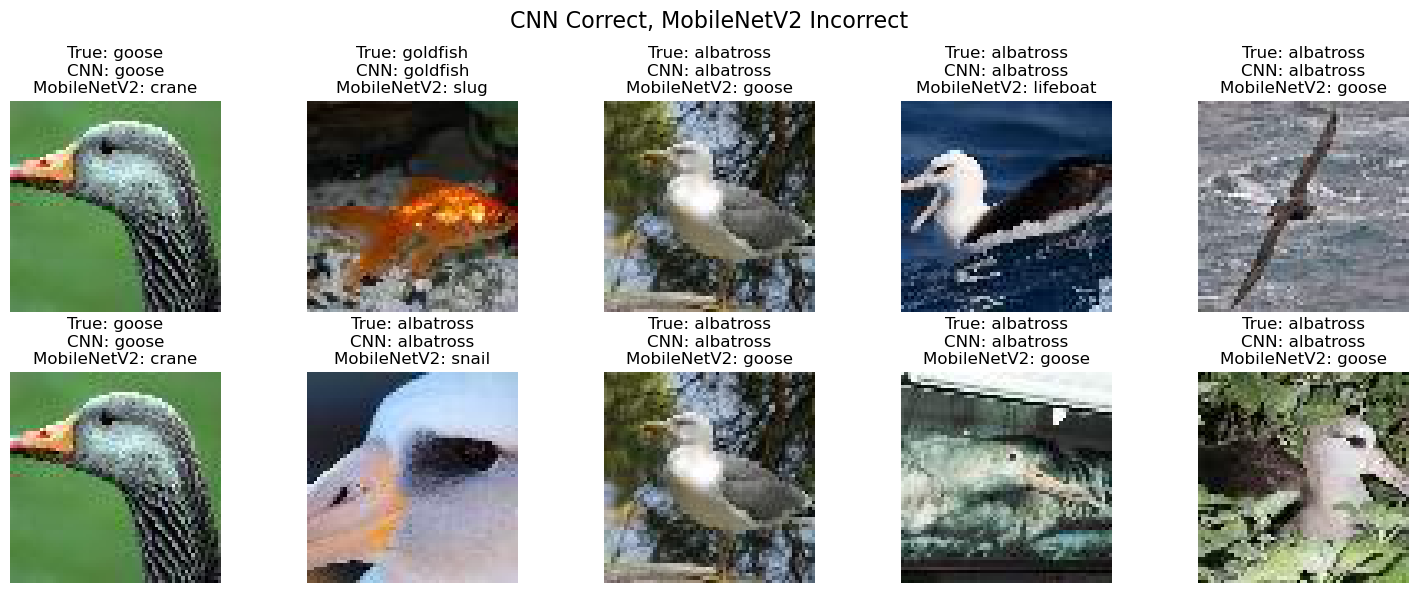

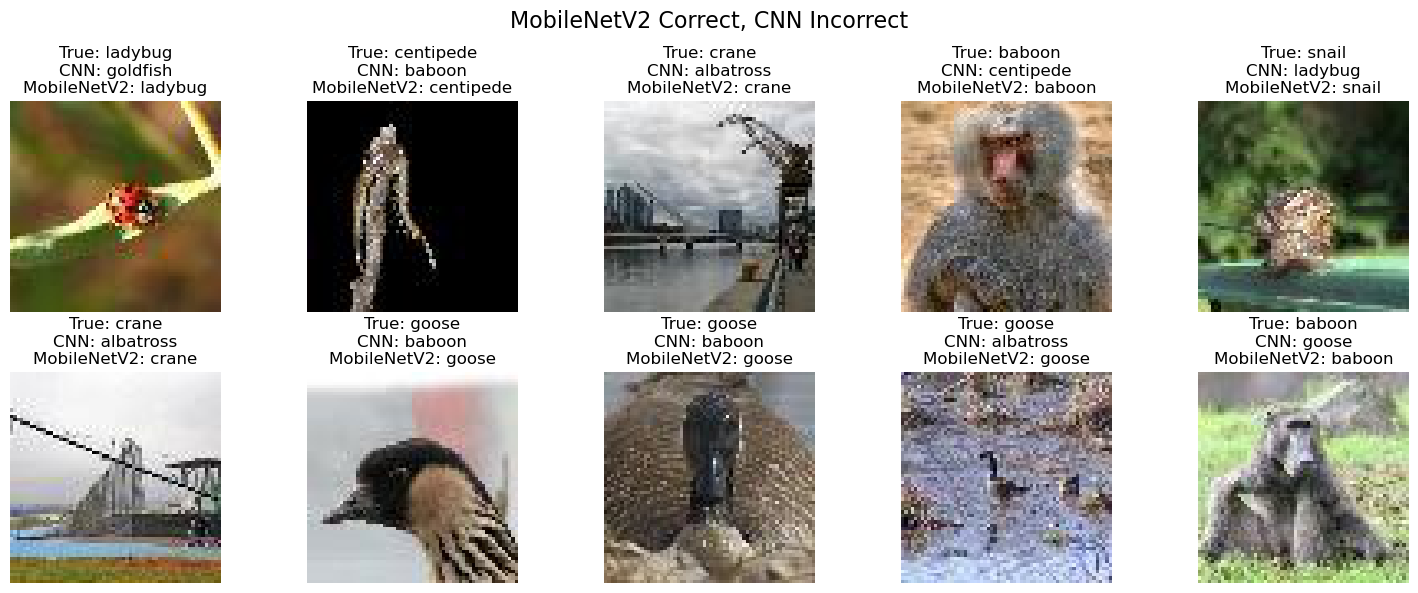

In [161]:
def get_indices(y_true, y_pred_cnn, y_pred_mnv2, condition):
    if condition == 'both_correct':
        indices = np.where((y_true == y_pred_cnn) & (y_true == y_pred_mnv2))[0]
    elif condition == 'both_incorrect':
        indices = np.where((y_true != y_pred_cnn) & (y_true != y_pred_mnv2))[0]
    elif condition == 'cnn_correct_mobilenetv2_incorrect':
        indices = np.where((y_true == y_pred_cnn) & (y_true != y_pred_mnv2))[0]
    elif condition == 'mobilenetv2_correct_cnn_incorrect':
        indices = np.where((y_true == y_pred_mnv2) & (y_true != y_pred_cnn))[0]
    else:
        raise ValueError("Invalid condition")
    return indices

both_correct_indices = get_indices(y_val, cnn_val_pred, mnv2_val_pred, 'both_correct')
both_incorrect_indices = get_indices(y_val, cnn_val_pred, mnv2_val_pred, 'both_incorrect')
only_cnn_correct_indices = get_indices(y_val, cnn_val_pred, mnv2_val_pred, 'cnn_correct_mobilenetv2_incorrect')
only_mnv2_correct_indices = get_indices(y_val, cnn_val_pred, mnv2_val_pred, 'mobilenetv2_correct_cnn_incorrect')
both_predictions = (cnn_val_pred, mnv2_val_pred)

displayImages(X_val, y_val, class_names, 10, "Both Models Correct", 
              preds=both_predictions, condition_indices=both_correct_indices)
displayImages(X_val, y_val, class_names, 10, "Both Models Incorrect",
              preds=both_predictions, condition_indices=both_incorrect_indices)
displayImages(X_val, y_val, class_names, 10, "CNN Correct, MobileNetV2 Incorrect",
              preds=both_predictions, condition_indices=only_cnn_correct_indices)
displayImages(X_val, y_val, class_names, 10, "MobileNetV2 Correct, CNN Incorrect",
              preds=both_predictions, condition_indices=only_mnv2_correct_indices)